# ReConnect

ReConnect is an AI-powered real estate opportunity system designed to help agents to find the best investment opportunities for a client.

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib

# Set style for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:
# Load the dataset
df = pd.read_csv("Real Estate Data V21.csv")

print(f"Total properties: {len(df):,}")
print(f"\nColumns in dataset: {df.columns.tolist()}")

df.head()

Total properties: 14,528

Columns in dataset: ['Name', 'Property Title', 'Price', 'Location', 'Total_Area', 'Price_per_SQFT', 'Description', 'Baths', 'Balcony']


,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes


### Checking and Reading Data

In [3]:
# Check data types and missing values
print("Dataset Info:")

df.info()

print("\n Missing Values:")

print(df.isnull().sum())

print("\n Statistical Summary:")

df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14528 entries, 0 to 14527
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            14528 non-null  object 
 1   Property Title  14528 non-null  object 
 2   Price           14528 non-null  object 
 3   Location        14528 non-null  object 
 4   Total_Area      14528 non-null  int64  
 5   Price_per_SQFT  14528 non-null  float64
 6   Description     14528 non-null  object 
 7   Baths           14528 non-null  int64  
 8   Balcony         14528 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 1021.6+ KB

 Missing Values:
Name              0
Property Title    0
Price             0
Location          0
Total_Area        0
Price_per_SQFT    0
Description       0
Baths             0
Balcony           0
dtype: int64

 Statistical Summary:


,Total_Area,Price_per_SQFT,Baths
count,14528.000000,14528.000000,14528.000000
mean,1297.916988,11719.456222,2.751239
std,1245.694305,49036.068632,0.898243
min,70.000000,0.000000,1.000000
25%,650.000000,4480.000000,2.000000
50%,1000.000000,6050.000000,3.000000
75%,1439.000000,9312.500000,3.000000
max,35000.000000,999000.000000,6.000000


## Data Cleaning

In [4]:
# Make a copy to work with
df_clean = df.copy()

# 1. Extract BHK (number of bedrooms) from Property Title
def extract_bhk(title):
    """Extract number of bedrooms from property title"""
    match = re.search(r'(\d+)\s*BHK', str(title))
    if match:
        return int(match.group(1))
    return None

df_clean['BHK'] = df_clean['Property Title'].apply(extract_bhk)
print(f"Extracted BHK information")

# 2. Clean Price column (remove ₹, Cr, L symbols and convert to numeric)
def clean_price(price):
    """Convert price string to numeric value in Lakhs"""
    try:
        price_str = str(price).replace('₹', '').replace(',', '').strip()
        
        if 'Cr' in price_str:
            # Convert Crores to Lakhs (1 Cr = 100 L)
            value = float(price_str.replace('Cr', '').strip())
            return value * 100
        elif 'L' in price_str:
            # Already in Lakhs
            value = float(price_str.replace('L', '').strip())
            return value
        else:
            return None
    except:
        return None

df_clean['Price_Lakhs'] = df_clean['Price'].apply(clean_price)
print(f"Cleaned price data (converted to Lakhs)")

# 3. Rename columns for clarity
df_clean = df_clean.rename(columns={
    'Total_Area': 'Total_Sqft',
    'Baths': 'Bathrooms'
})

# 4. Select only the columns we need
df_clean = df_clean[['BHK', 'Total_Sqft', 'Bathrooms', 'Price_per_SQFT', 'Price_Lakhs', 'Location']]

# 5. Drop rows with missing values
initial_rows = len(df_clean)
df_clean = df_clean.dropna()
rows_dropped = initial_rows - len(df_clean)

print(f" Dropped {rows_dropped:,} rows with missing values")
print(f"\n Final dataset shape: {df_clean.shape}")
print(f"   Rows: {df_clean.shape[0]:,}")
print(f"   Columns: {df_clean.shape[1]}")

# Display cleaned data
df_clean.head(10)

Extracted BHK information
Cleaned price data (converted to Lakhs)
 Dropped 756 rows with missing values

 Final dataset shape: (13772, 6)
   Rows: 13,772
   Columns: 6


,BHK,Total_Sqft,Bathrooms,Price_per_SQFT,Price_Lakhs,Location
0,4.0,2583,4,7700.0,199.00,"Kanathur Reddikuppam, Chennai"
1,10.0,7000,6,3210.0,225.00,"Ramanathan Nagar, Pozhichalur,Chennai"
2,3.0,1320,3,7580.0,100.00,"Kasthuribai Nagar, West Tambaram,Chennai"
3,7.0,4250,5,7840.0,333.00,"Naveenilaya,Chepauk, Triplicane,Chennai"
4,2.0,960,3,5000.0,48.00,"Avadi, Chennai"
5,2.0,940,3,4250.0,40.00,"Siruseri, Chennai"
6,2.0,880,3,6820.0,60.00,"THIRAN FLATS ,Gowrivakkam, Sembakkam,Chennai"
7,3.0,1700,3,4250.0,72.35,"Mahindra World City, Chennai"
8,2.0,840,3,5000.0,42.00,"Brindavan Colony, West Tambaram,Chennai"
9,1.0,535,2,5610.0,30.00,"New Colony, Chromepet,Chennai"


### Removing Outliers

In [5]:

initial_count = len(df_clean)

# Remove unrealistic square footage (keep properties < 15,000 sqft)
df_clean = df_clean[df_clean['Total_Sqft'] < 15000]
sqft_removed = initial_count - len(df_clean)

# Remove unrealistic BHK values (keep BHK < 15)
temp_count = len(df_clean)
df_clean = df_clean[df_clean['BHK'] < 15]
bhk_removed = temp_count - len(df_clean)


# Remove extreme price outliers (keep prices < 10,000 Lakhs)
temp_count = len(df_clean)
df_clean = df_clean[df_clean['Price_Lakhs'] < 10000]
price_removed = temp_count - len(df_clean)

# Remove properties with unrealistic price per sqft
temp_count = len(df_clean)
df_clean = df_clean[(df_clean['Price_per_SQFT'] > 500) & (df_clean['Price_per_SQFT'] < 50000)]
price_per_sqft_removed = temp_count - len(df_clean)


total_removed = initial_count - len(df_clean)
print(f"\nTotal outliers removed: {total_removed:,} ({total_removed/initial_count*100:.2f}%)")
print(f" Final dataset size: {len(df_clean):,} properties")

# Show statistical summary after cleaning
print("\nStatistical Summary After Cleaning:")

df_clean.describe()


Total outliers removed: 157 (1.14%)
 Final dataset size: 13,615 properties

Statistical Summary After Cleaning:


,BHK,Total_Sqft,Bathrooms,Price_per_SQFT,Price_Lakhs
count,13615.000000,13615.000000,13615.000000,13615.000000,13615.000000
mean,2.633566,1307.128388,2.812853,7956.287918,106.673569
std,1.623630,1069.883054,0.850218,6020.008862,176.365526
min,1.000000,150.000000,1.000000,1000.000000,4.500000
25%,2.000000,700.000000,2.000000,4490.000000,40.000000
50%,2.000000,1016.000000,3.000000,6000.000000,65.000000
75%,3.000000,1462.500000,3.000000,9000.000000,117.000000
max,10.000000,14000.000000,6.000000,49670.000000,8400.000000


FEATURE ENGINEERING AND MODEL TRAINING

1. One-hot encoding 'Location' column...
   Features after encoding: 6659 columns

2. Dataset shape for modeling:
   X (features): (13615, 6658)
   y (target): (13615,)

3. Splitting data into train/test sets (80/20 split)...
   Training set: 10892 samples
   Test set: 2723 samples

4. Training Random Forest Regressor...
   Model training complete!

5. Making predictions...

6. Model Evaluation Results:
------------------------------
   Mean Absolute Error (MAE): ₹7.73 Lakhs
   R² Score: 0.4134
   Root Mean Squared Error (RMSE): ₹136.19 Lakhs

7. Top 10 Most Important Features:
------------------------------
                                  Feature  Importance
                               Total_Sqft    0.465328
                           Price_per_SQFT    0.459070
                                      BHK    0.046256
                  Location_Balewadi, Pune    0.019707
                                Bathrooms    0.007243
        Location_Har

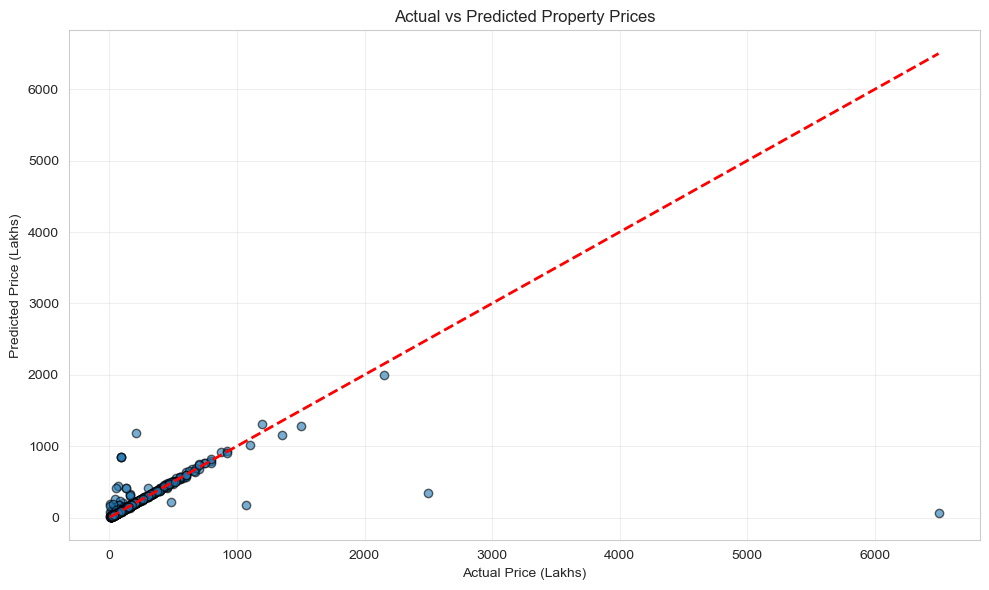


MODEL TRAINING COMPLETE!


In [6]:

# FEATURE ENGINEERING & MODEL TRAINING


print("FEATURE ENGINEERING AND MODEL TRAINING")


# 1. Feature Engineering - One-hot encode Location
print("\n1. One-hot encoding 'Location' column...")
df_model = pd.get_dummies(df_clean, columns=['Location'], drop_first=True)

print(f"   Features after encoding: {df_model.shape[1]} columns")

# 2. Prepare features and target
X = df_model.drop('Price_Lakhs', axis=1)
y = df_model['Price_Lakhs']

print(f"\n2. Dataset shape for modeling:")
print(f"   X (features): {X.shape}")
print(f"   y (target): {y.shape}")

# 3. Split data
print("\n3. Splitting data into train/test sets (80/20 split)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")

# 4. Train Random Forest Model
print("\n4. Training Random Forest Regressor...")
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1  # Use all processors
)

model.fit(X_train, y_train)
print("   Model training complete!")

# 5. Make predictions
print("\n5. Making predictions...")
y_pred = model.predict(X_test)

# 6. Evaluate model
print("\n6. Model Evaluation Results:")
print("-" * 30)
print(f"   Mean Absolute Error (MAE): ₹{mean_absolute_error(y_test, y_pred):.2f} Lakhs")
print(f"   R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"   Root Mean Squared Error (RMSE): ₹{np.sqrt(mean_squared_error(y_test, y_pred)):.2f} Lakhs")

# 7. Feature Importance
print("\n7. Top 10 Most Important Features:")
print("-" * 30)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

# 8. Save the model
print("\n8. Saving the trained model...")
joblib.dump(model, 'reconnect_real_estate_model.pkl')
print("   Model saved as 'reconnect_real_estate_model.pkl'")

# 9. Visualize predictions vs actual
print("\n9. Creating visualization...")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (Lakhs)')
plt.ylabel('Predicted Price (Lakhs)')
plt.title('Actual vs Predicted Property Prices')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*50)
print("MODEL TRAINING COMPLETE!")
print("="*50)

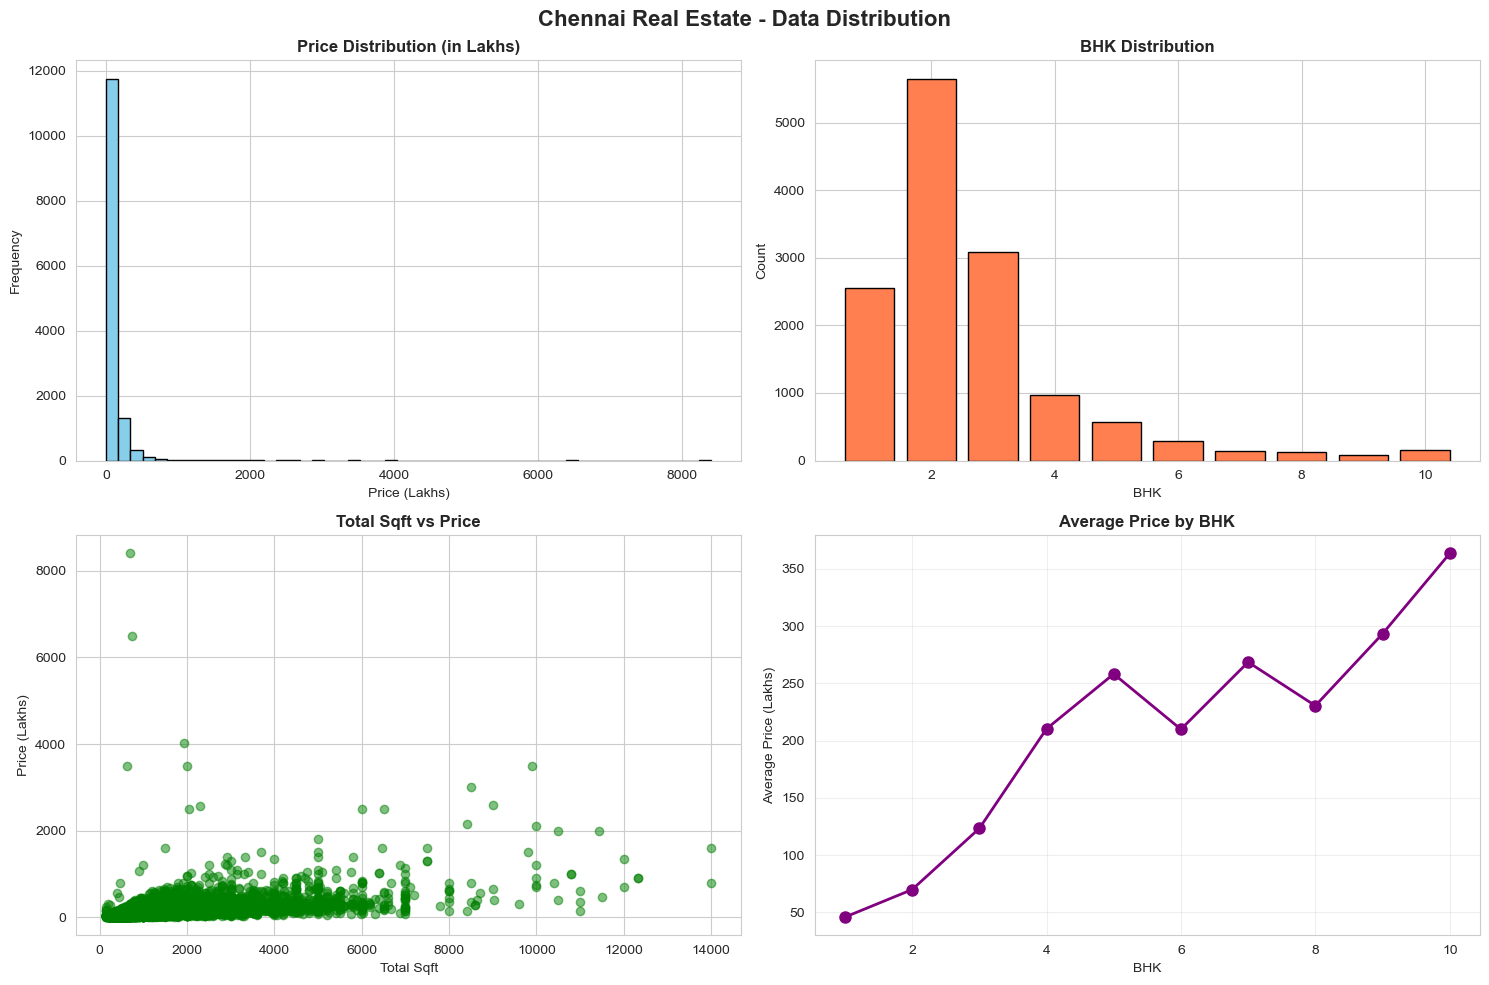


 Key Insights:
   Average Property Price: ₹106.67 Lakhs
   Median Property Price: ₹65.00 Lakhs
   Most Common BHK: 2.0 BHK
   Average Square Footage: 1307 sqft


In [7]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Chennai Real Estate - Data Distribution', fontsize=16, fontweight='bold')

# Plot 1: Price Distribution
axes[0, 0].hist(df_clean['Price_Lakhs'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Price Distribution (in Lakhs)', fontweight='bold')
axes[0, 0].set_xlabel('Price (Lakhs)')
axes[0, 0].set_ylabel('Frequency')

# Plot 2: BHK Distribution
bhk_counts = df_clean['BHK'].value_counts().sort_index()
axes[0, 1].bar(bhk_counts.index, bhk_counts.values, color='coral', edgecolor='black')
axes[0, 1].set_title('BHK Distribution', fontweight='bold')
axes[0, 1].set_xlabel('BHK')
axes[0, 1].set_ylabel('Count')

# Plot 3: Total Sqft vs Price
axes[1, 0].scatter(df_clean['Total_Sqft'], df_clean['Price_Lakhs'], alpha=0.5, color='green')
axes[1, 0].set_title('Total Sqft vs Price', fontweight='bold')
axes[1, 0].set_xlabel('Total Sqft')
axes[1, 0].set_ylabel('Price (Lakhs)')

# Plot 4: Average Price by BHK
avg_price_by_bhk = df_clean.groupby('BHK')['Price_Lakhs'].mean()
axes[1, 1].plot(avg_price_by_bhk.index, avg_price_by_bhk.values, marker='o', 
                linewidth=2, markersize=8, color='purple')
axes[1, 1].set_title('Average Price by BHK', fontweight='bold')
axes[1, 1].set_xlabel('BHK')
axes[1, 1].set_ylabel('Average Price (Lakhs)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Key Insights:")
print(f"   Average Property Price: ₹{df_clean['Price_Lakhs'].mean():.2f} Lakhs")
print(f"   Median Property Price: ₹{df_clean['Price_Lakhs'].median():.2f} Lakhs")
print(f"   Most Common BHK: {df_clean['BHK'].mode()[0]} BHK")
print(f"   Average Square Footage: {df_clean['Total_Sqft'].mean():.0f} sqft")

In [8]:
# Define features (X) and target (y)
X = df_clean[['Total_Sqft', 'Bathrooms', 'BHK']]
y = df_clean['Price_Lakhs']

print(" Features (X) prepared:")
print(f"   Shape: {X.shape}")
print(f"   Columns: {list(X.columns)}")

print("\n Target (y) prepared:")
print(f"   Shape: {y.shape}")
print(f"   Variable: Price_Lakhs")

# Display sample
print("\n Sample of Features:")
X.head()


 Features (X) prepared:
   Shape: (13615, 3)
   Columns: ['Total_Sqft', 'Bathrooms', 'BHK']

 Target (y) prepared:
   Shape: (13615,)
   Variable: Price_Lakhs

 Sample of Features:


,Total_Sqft,Bathrooms,BHK
0,2583,4,4.0
1,7000,6,10.0
2,1320,3,3.0
3,4250,5,7.0
4,960,3,2.0


In [9]:
# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {len(X_train):,} properties ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set size:  {len(X_test):,} properties ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining set price range: ₹{y_train.min():.2f}L - ₹{y_train.max():.2f}L")
print(f"Testing set price range:  ₹{y_test.min():.2f}L - ₹{y_test.max():.2f}L")

Training set size: 10,892 properties (80.0%)
Testing set size:  2,723 properties (20.0%)

Training set price range: ₹4.50L - ₹8400.00L
Testing set price range:  ₹5.50L - ₹6500.00L


In [10]:

# Create and train the model
model = RandomForestRegressor(
    n_estimators=200,      
    max_depth=20,          
    min_samples_split=5,   
    random_state=42,
    n_jobs=-1             
)

# Fit the model
model.fit(X_train, y_train)


print(f"\n Model Parameters:")
print(f"   Number of trees: {model.n_estimators}")
print(f"   Max tree depth: {model.max_depth}")
print(f"   Features used: {list(X.columns)}")


 Model Parameters:
   Number of trees: 200
   Max tree depth: 20
   Features used: ['Total_Sqft', 'Bathrooms', 'BHK']


### Model Evaluation

MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE):  ₹55.41 Lakhs
Root Mean Squared Error (RMSE): ₹173.99 Lakhs
R² Score (Accuracy):  0.0425 (4.25%)
   • On average, our predictions are off by ₹55.41 Lakhs
   • The model explains 4.25% of the price variation
   • Fair model performance!


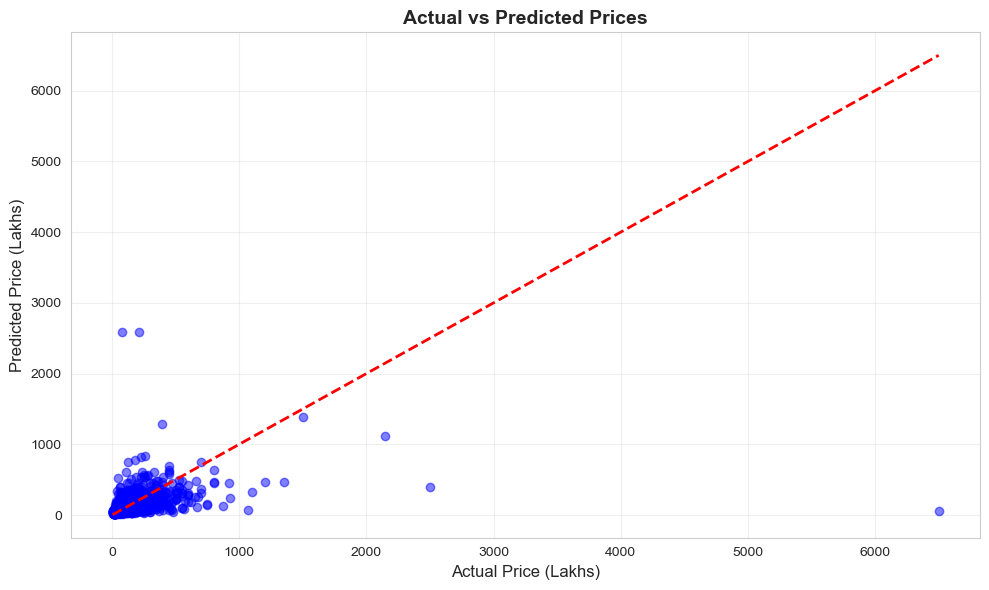


 Sample Predictions (first 10 test properties):
Actual Price Predicted Price Difference
    ₹100.00L         ₹66.41L    ₹33.59L
     ₹90.00L         ₹74.12L    ₹15.88L
     ₹60.00L         ₹92.30L    ₹32.30L
     ₹72.00L         ₹71.60L     ₹0.40L
     ₹65.00L        ₹166.99L   ₹101.99L
    ₹115.00L        ₹150.44L    ₹35.44L
     ₹34.00L         ₹77.05L    ₹43.05L
    ₹127.00L         ₹77.56L    ₹49.44L
    ₹570.00L         ₹85.00L   ₹485.00L
     ₹29.00L         ₹51.62L    ₹22.62L


In [11]:

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print("MODEL PERFORMANCE METRICS")

print(f"Mean Absolute Error (MAE):  ₹{mae:.2f} Lakhs")
print(f"Root Mean Squared Error (RMSE): ₹{rmse:.2f} Lakhs")
print(f"R² Score (Accuracy):  {r2:.4f} ({r2*100:.2f}%)")


# What does this mean?

print(f"   • On average, our predictions are off by ₹{mae:.2f} Lakhs")
print(f"   • The model explains {r2*100:.2f}% of the price variation")
print(f"   • {'Excellent' if r2 > 0.9 else 'Good' if r2 > 0.8 else 'Decent' if r2 > 0.7 else 'Fair'} model performance!")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (Lakhs)', fontsize=12)
plt.ylabel('Predicted Price (Lakhs)', fontsize=12)
plt.title('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show some example predictions
print("\n Sample Predictions (first 10 test properties):")

comparison = pd.DataFrame({
    'Actual Price': y_test.head(10).values,
    'Predicted Price': y_pred[:10],
    'Difference': np.abs(y_test.head(10).values - y_pred[:10])
})
comparison['Actual Price'] = comparison['Actual Price'].apply(lambda x: f"₹{x:.2f}L")
comparison['Predicted Price'] = comparison['Predicted Price'].apply(lambda x: f"₹{x:.2f}L")
comparison['Difference'] = comparison['Difference'].apply(lambda x: f"₹{x:.2f}L")
print(comparison.to_string(index=False))


Feature Importance Rankings:
   Total_Sqft     : 0.8298 (82.98%)
   BHK            : 0.1262 (12.62%)
   Bathrooms      : 0.0441 (4.41%)


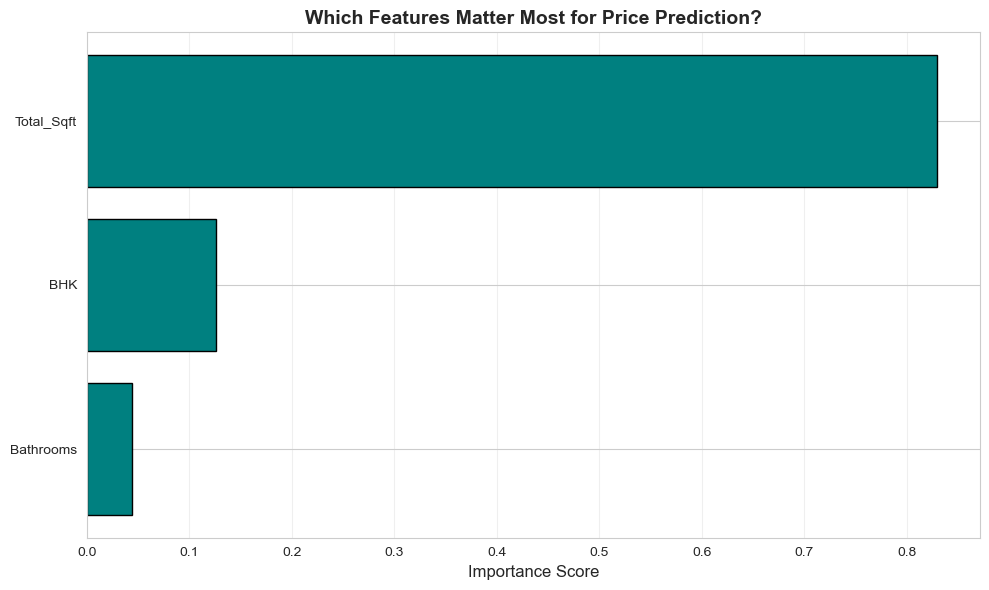


 Insight:
   'Total_Sqft' is the most important factor, accounting for 83.0% of price variation!


In [12]:
# Get feature importance
feature_importance = model.feature_importances_
features = X.columns

# Create a dataframe for better visualisation
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Feature Importance Rankings:")

for idx, row in importance_df.iterrows():
    print(f"   {row['Feature']:15s}: {row['Importance']:.4f} ({row['Importance']*100:.2f}%)")

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal', edgecolor='black')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Which Features Matter Most for Price Prediction?', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Insight:")
top_feature = importance_df.iloc[0]['Feature']
top_importance = importance_df.iloc[0]['Importance']
print(f"   '{top_feature}' is the most important factor, accounting for {top_importance*100:.1f}% of price variation!")

### Saving Model

In [13]:
# Save the trained model
import os
import joblib

# Save the trained model
model_filename = 'chennai_property_model.pkl'
joblib.dump(model, model_filename)

print(f"Model saved successfully as '{model_filename}'")
print(f"\n Model file size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")
print("\n You can now load this model anytime using:")
print(f"   model = joblib.load('{model_filename}')")

model_filename = 'chennai_property_model.pkl'
joblib.dump(model, model_filename)

print(f" Model saved successfully as '{model_filename}'")
print(f"\n Model file size: {os.path.getsize(model_filename) / (1024*1024):.2f} MB")
print("\nYou can now load this model anytime using:")
print(f"   model = joblib.load('{model_filename}')")

Model saved successfully as 'chennai_property_model.pkl'

 Model file size: 39.28 MB

 You can now load this model anytime using:
   model = joblib.load('chennai_property_model.pkl')
 Model saved successfully as 'chennai_property_model.pkl'

 Model file size: 39.28 MB

You can now load this model anytime using:
   model = joblib.load('chennai_property_model.pkl')


In [14]:
def investment_score(sqft, bathrooms, bhk, actual_price=None, location=None):
    """
    Calculate investment opportunity score for a property.
    
    Parameters:
    -----------
    sqft : int/float
        Total square footage of the property
    bathrooms : int
        Number of bathrooms
    bhk : int
        Number of bedrooms (BHK)
    actual_price : float, optional
        Actual market price in Lakhs (if known)
    location : str, optional
        Property location
    
    Returns:
    --------
    dict : Investment analysis results
    """
    
    # Load the trained model
    model = joblib.load('chennai_property_model.pkl')
    
    # Prepare input data
    input_data = pd.DataFrame([[sqft, bathrooms, bhk]],
                              columns=['Total_Sqft', 'Bathrooms', 'BHK'])
    
    # Get predicted price
    predicted_price = model.predict(input_data)[0]
    
    # Calculate price per sqft
    pred_price_per_sqft = (predicted_price * 100000) / sqft  # Convert Lakhs to rupees
    
    # Investment scoring logic (0-100 scale)
    base_score = 50  # Start with neutral score
    
    # Factor 1: Size bonus (larger properties get slight premium)
    size_score = min(sqft / 100, 20)  # Max 20 points
    
    # Factor 2: BHK configuration (3-4 BHK are most desirable)
    if bhk == 3 or bhk == 4:
        bhk_score = 15
    elif bhk == 2:
        bhk_score = 10
    elif bhk == 1:
        bhk_score = 5
    else:
        bhk_score = 8
    
    # Factor 3: Bathroom ratio (ideal is BHK = Bathrooms or Bathrooms = BHK + 1)
    bath_score = 10 if (bathrooms >= bhk and bathrooms <= bhk + 1) else 5
    
    # Calculate total score
    total_score = base_score + size_score + bhk_score + bath_score
    
    # If actual price is provided, calculate value opportunity
    value_opportunity = None
    recommendation = None
    
    if actual_price is not None:
        price_diff = actual_price - predicted_price
        price_diff_pct = (price_diff / predicted_price) * 100
        
        # Adjust score based on pricing
        if price_diff_pct < -10:  # Underpriced by 10%+
            total_score += 15
            value_opportunity = "Excellent Deal! "
            recommendation = "Strong Buy"
        elif price_diff_pct < 0:  # Any underpricing
            total_score += 10
            value_opportunity = "Good Value "
            recommendation = "Buy"
        elif price_diff_pct < 10:  # Fairly priced
            total_score += 5
            value_opportunity = "Fair Price ✓"
            recommendation = "Hold/Consider"
        else:  # Overpriced
            total_score -= 5
            value_opportunity = "Overpriced "
            recommendation = "Negotiate/Pass"
    
    # Cap score at 100
    total_score = min(total_score, 100)
    
    # Prepare results
    results = {
        'predicted_price_lakhs': round(predicted_price, 2),
        'predicted_price_cr': round(predicted_price / 100, 2),
        'price_per_sqft': round(pred_price_per_sqft, 2),
        'investment_score': round(total_score, 1),
        'score_breakdown': {
            'base': base_score,
            'size_bonus': round(size_score, 1),
            'bhk_bonus': bhk_score,
            'bathroom_bonus': bath_score
        }
    }
    
    if actual_price is not None:
        results['actual_price_lakhs'] = round(actual_price, 2)
        results['price_difference_lakhs'] = round(price_diff, 2)
        results['price_difference_percent'] = round(price_diff_pct, 2)
        results['value_opportunity'] = value_opportunity
        results['recommendation'] = recommendation
    
    if location:
        results['location'] = location
    
    return results

print(" Investment scoring function created!")
print("\n Function features:")
print("   • ML-based price prediction")
print("   • Multi-factor scoring (size, BHK, bathrooms)")
print("   • Value opportunity detection")
print("   • Investment recommendations")

 Investment scoring function created!

 Function features:
   • ML-based price prediction
   • Multi-factor scoring (size, BHK, bathrooms)
   • Value opportunity detection
   • Investment recommendations


In [15]:
# Test Case 1: Standard 3 BHK apartment
bhk = 3
bathrooms = 3
sqft = 1500
location = "Anna Nagar"
actual_price = 85  # in Lakhs

print("\nTEST PROPERTY 1: 3 BHK Apartment")

result1 = investment_score(sqft=sqft, bathrooms=bathrooms, bhk=bhk, actual_price=actual_price, location=location)

print(f"Location: {result1.get('location', location)}")
print(f"Configuration: {bhk} BHK, {bathrooms} Bathrooms, {sqft} sqft")
print(f"\nPredicted Price: Rs {result1['predicted_price_lakhs']} Lakhs (Rs {result1['predicted_price_cr']} Cr)")
print(f"Predicted Price/SqFt: Rs {result1['price_per_sqft']:.2f}")

if 'actual_price_lakhs' in result1:
    print(f"\nActual Market Price: Rs {result1['actual_price_lakhs']} Lakhs")
    print(f"Price Difference: Rs {result1['price_difference_lakhs']} Lakhs ({result1['price_difference_percent']:+.2f}%)")
    print(f"Value Assessment: {result1['value_opportunity']}")
    print(f"Recommendation: {result1['recommendation']}")

print(f"\nINVESTMENT SCORE: {result1['investment_score']}/100")
print(f"Score Breakdown: Base={result1['score_breakdown']['base']}, "
      f"Size={result1['score_breakdown']['size_bonus']}, "
      f"BHK={result1['score_breakdown']['bhk_bonus']}, "
      f"Bath={result1['score_breakdown']['bathroom_bonus']}")

# Test Case 2: Luxury 4 BHK
bhk = 4
bathrooms = 4
sqft = 2500
location = "Velachery"
actual_price = 280  # in Lakhs

print("\n\nTEST PROPERTY 2: Luxury 4 BHK Apartment")

result2 = investment_score(sqft=sqft, bathrooms=bathrooms, bhk=bhk, actual_price=actual_price, location=location)

print(f"Location: {result2.get('location', location)}")
print(f"Configuration: {bhk} BHK, {bathrooms} Bathrooms, {sqft} sqft")
print(f"\nPredicted Price: Rs {result2['predicted_price_lakhs']} Lakhs (Rs {result2['predicted_price_cr']} Cr)")
print(f"Predicted Price/SqFt: Rs {result2['price_per_sqft']:.2f}")

if 'actual_price_lakhs' in result2:
    print(f"\nActual Market Price: Rs {result2['actual_price_lakhs']} Lakhs")
    print(f"Price Difference: Rs {result2['price_difference_lakhs']} Lakhs ({result2['price_difference_percent']:+.2f}%)")
    print(f"Value Assessment: {result2['value_opportunity']}")
    print(f"Recommendation: {result2['recommendation']}")

print(f"\nINVESTMENT SCORE: {result2['investment_score']}/100")

# Test Case 3: Compact 2 BHK
bhk = 2
bathrooms = 2
sqft = 1000

print("\n\nTEST PROPERTY 3: Compact 2 BHK Apartment")

result3 = investment_score(sqft=sqft, bathrooms=bathrooms, bhk=bhk)

print(f"Configuration: {bhk} BHK, {bathrooms} Bathrooms, {sqft} sqft")
print(f"\nPredicted Price: Rs {result3['predicted_price_lakhs']} Lakhs (Rs {result3['predicted_price_cr']} Cr)")
print(f"Predicted Price/SqFt: Rs {result3['price_per_sqft']:.2f}")
print(f"\nINVESTMENT SCORE: {result3['investment_score']}/100")




TEST PROPERTY 1: 3 BHK Apartment
Location: Anna Nagar
Configuration: 3 BHK, 3 Bathrooms, 1500 sqft

Predicted Price: Rs 131.63 Lakhs (Rs 1.32 Cr)
Predicted Price/SqFt: Rs 8775.32

Actual Market Price: Rs 85 Lakhs
Price Difference: Rs -46.63 Lakhs (-35.42%)
Value Assessment: Excellent Deal! 
Recommendation: Strong Buy

INVESTMENT SCORE: 100/100
Score Breakdown: Base=50, Size=15.0, BHK=15, Bath=10


TEST PROPERTY 2: Luxury 4 BHK Apartment
Location: Velachery
Configuration: 4 BHK, 4 Bathrooms, 2500 sqft

Predicted Price: Rs 284.84 Lakhs (Rs 2.85 Cr)
Predicted Price/SqFt: Rs 11393.46

Actual Market Price: Rs 280 Lakhs
Price Difference: Rs -4.84 Lakhs (-1.70%)
Value Assessment: Good Value 
Recommendation: Buy

INVESTMENT SCORE: 100/100


TEST PROPERTY 3: Compact 2 BHK Apartment
Configuration: 2 BHK, 2 Bathrooms, 1000 sqft

Predicted Price: Rs 71.6 Lakhs (Rs 0.72 Cr)
Predicted Price/SqFt: Rs 7160.43

INVESTMENT SCORE: 80.0/100


In [16]:
def analyze_property(sqft, bathrooms, bhk, actual_price=None, location=None):
    """
    User-friendly property analysis function with formatted output.
    """
    result = investment_score(sqft, bathrooms, bhk, actual_price, location)
    
  
    print("PROPERTY INVESTMENT ANALYSIS REPORT")
    
    
    if location:
        print(f"\n Location: {location}")
    
    print(f"\n Property Details:")
    print(f"   • Configuration: {bhk} BHK")
    print(f"   • Bathrooms: {bathrooms}")
    print(f"   • Total Area: {sqft:,} sqft")
    
    print(f"\n Price Analysis:")
    print(f"   • AI Predicted Price: ₹{result['predicted_price_lakhs']:.2f} Lakhs (₹{result['predicted_price_cr']:.2f} Cr)")
    print(f"   • Price per SqFt: ₹{result['price_per_sqft']:,.2f}")
    
    if 'actual_price_lakhs' in result:
        print(f"   • Market Price: ₹{result['actual_price_lakhs']:.2f} Lakhs")
        print(f"   • Difference: ₹{result['price_difference_lakhs']:.2f} Lakhs ({result['price_difference_percent']:+.2f}%)")
        
        print(f"\n Value Assessment: {result['value_opportunity']}")
        print(f" Recommendation: {result['recommendation']}")
    
    # Score visualization
    score = result['investment_score']
    print(f"\n INVESTMENT SCORE: {score}/100")
    
    # Visual score bar
    bar_length = int(score / 2)  # Scale to 50 chars
    bar = '█' * bar_length + '░' * (50 - bar_length)
    print(f"   [{bar}]")
    
    # Score interpretation
    if score >= 85:
        rating = "Excellent Investment"
    elif score >= 75:
        rating = " Great Investment"
    elif score >= 65:
        rating = "Good Investment"
    elif score >= 55:
        rating = "Fair Investment"
    else:
        rating = " Consider Other Options"
    
    print(f"   {rating}")
    
    
    return result

print(" Interactive calculator ready!")
print("\n Example usage:")
print("   analyze_property(sqft=1500, bathrooms=3, bhk=3, actual_price=85, location='T Nagar')")
print("\n Try analyzing your own property below!")

 Interactive calculator ready!

 Example usage:
   analyze_property(sqft=1500, bathrooms=3, bhk=3, actual_price=85, location='T Nagar')

 Try analyzing your own property below!


### Analysing Property

In [17]:
#  Modify these values to analyse your property

my_property = analyze_property(
    sqft=1800,              
    bathrooms=3,            
    bhk=3,                 
    actual_price=95,       
    location="Adyar"        
)

# Access individual results if needed
print(f"\n Quick Summary:")
print(f"   Predicted: ₹{my_property['predicted_price_cr']} Cr")
print(f"   Score: {my_property['investment_score']}/100")

PROPERTY INVESTMENT ANALYSIS REPORT

 Location: Adyar

 Property Details:
   • Configuration: 3 BHK
   • Bathrooms: 3
   • Total Area: 1,800 sqft

 Price Analysis:
   • AI Predicted Price: ₹174.69 Lakhs (₹1.75 Cr)
   • Price per SqFt: ₹9,704.90
   • Market Price: ₹95.00 Lakhs
   • Difference: ₹-79.69 Lakhs (-45.62%)

 Value Assessment: Excellent Deal! 
 Recommendation: Strong Buy

 INVESTMENT SCORE: 100/100
   [██████████████████████████████████████████████████]
   Excellent Investment

 Quick Summary:
   Predicted: ₹1.75 Cr
   Score: 100/100


 PROPERTY COMPARISON REPORT
  Property   Location              Config  Market Price (L)  Predicted (L)  Difference (%)  Investment Score Recommendation
Property 2 Anna Nagar 3BHK/3Bath/1500sqft                85         131.63          -35.42             100.0     Strong Buy
Property 3  Velachery 3BHK/3Bath/2000sqft               140         165.09          -15.20             100.0     Strong Buy
Property 4        OMR 4BHK/4Bath/2500sqft               210         284.84          -26.27             100.0     Strong Buy
Property 1  Chromepet 2BHK/2Bath/1200sqft                60          85.41          -29.75              97.0     Strong Buy


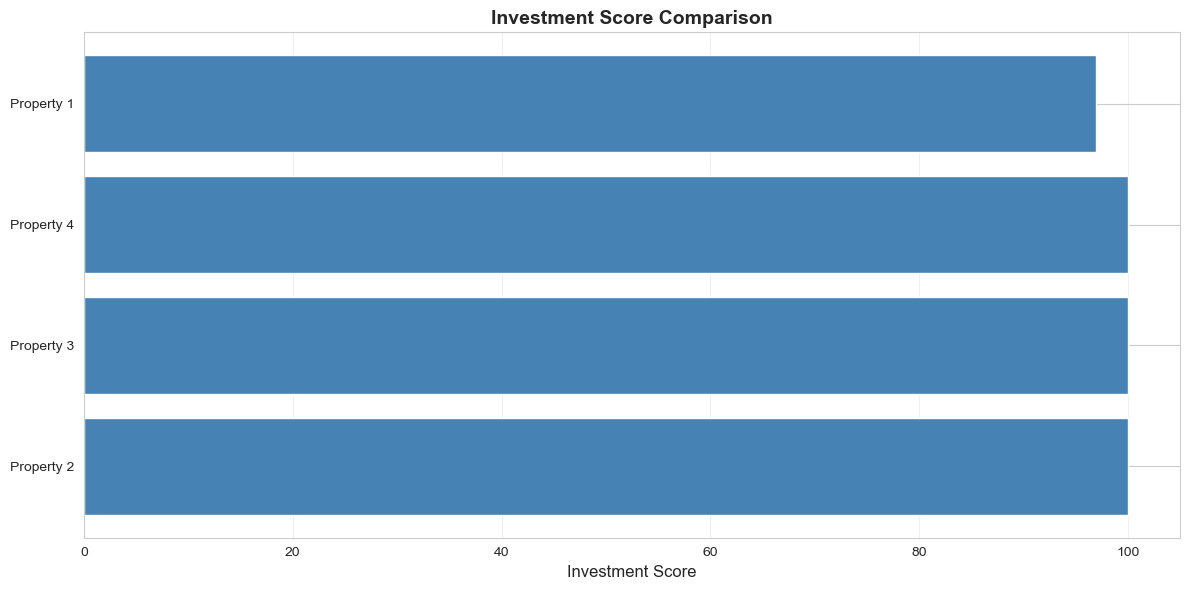


 BEST INVESTMENT OPPORTUNITY:
   Property 2 in Anna Nagar
   Score: 100.0/100
   Recommendation: Strong Buy


In [18]:
# Define multiple properties to compare
properties_to_compare = [
    {'sqft': 1200, 'bathrooms': 2, 'bhk': 2, 'actual_price': 60, 'location': 'Chromepet'},
    {'sqft': 1500, 'bathrooms': 3, 'bhk': 3, 'actual_price': 85, 'location': 'Anna Nagar'},
    {'sqft': 2000, 'bathrooms': 3, 'bhk': 3, 'actual_price': 140, 'location': 'Velachery'},
    {'sqft': 2500, 'bathrooms': 4, 'bhk': 4, 'actual_price': 210, 'location': 'OMR'},
]

results_list = []
for i, prop in enumerate(properties_to_compare, 1):
    result = investment_score(**prop)
    result['property_id'] = f"Property {i}"
    result['location'] = prop.get('location', 'N/A')
    result['config'] = f"{prop['bhk']}BHK/{prop['bathrooms']}Bath/{prop['sqft']}sqft"
    results_list.append(result)

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Property': r['property_id'],
        'Location': r['location'],
        'Config': r['config'],
        'Market Price (L)': r.get('actual_price_lakhs', 'N/A'),
        'Predicted (L)': r['predicted_price_lakhs'],
        'Difference (%)': r.get('price_difference_percent', 'N/A'),
        'Investment Score': r['investment_score'],
        'Recommendation': r.get('recommendation', 'N/A')
    }
    for r in results_list
])

# Sort by investment score
comparison_df = comparison_df.sort_values('Investment Score', ascending=False)

print(" PROPERTY COMPARISON REPORT")

print(comparison_df.to_string(index=False))


# Visual comparison
plt.figure(figsize=(12, 6))
plt.barh(comparison_df['Property'], comparison_df['Investment Score'], color='steelblue')
plt.xlabel('Investment Score', fontsize=12)
plt.title('Investment Score Comparison', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Best investment
best = comparison_df.iloc[0]
print(f"\n BEST INVESTMENT OPPORTUNITY:")
print(f"   {best['Property']} in {best['Location']}")
print(f"   Score: {best['Investment Score']}/100")
print(f"   Recommendation: {best['Recommendation']}")